


# Árboles de decisión II
## author: Virginia Ordoño Bernier
## date: february 2024

En este ejercicio se aplica el método **Gradient Boosting** al dataset Potabiliad Agua (clasificación).

Se usará también las técnicas de **GridSearch** y **RandomizedSearch** para la búsqueda de los mejores hiperparámetros. 

### 1. Gestión de datos

#### 1.1 Carga y creación del dataframe

In [11]:
import pandas as pd
import inflection
from sklearn import datasets


csv = './data/water_potability.csv'
data = pd.read_csv(csv)
df_water = pd.DataFrame(data)
df_water.columns = [inflection.underscore(col.replace(' ', '_').replace('(', '').replace(')', '')) for col in df_water.columns]
df_water.rename(columns={'potability': 'target'}, inplace=True)
df_water.head()


,ph,hardness,solids,chloramines,sulfate,conductivity,organic_carbon,trihalomethanes,turbidity,target
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [12]:
df_water.target.unique()

array([0, 1], dtype=int64)

### Gestión de nulos

In [13]:
print(f'Filas: {df_water.shape[0]}')
print(f'{df_water.isna().sum()}')


Filas: 3276
ph                 491
hardness             0
solids               0
chloramines          0
sulfate            781
conductivity         0
organic_carbon       0
trihalomethanes    162
turbidity            0
target               0
dtype: int64


In [14]:
# Calculamos la mediana para completar esos campos
median_per_column = df_water.median()

# Imputar los valores NaN con las medianas correspondientes
df_water = df_water.fillna(median_per_column)

# Verificar el DataFrame después de la imputación
nan_per_column = df_water.isna().sum()
nan_per_column

ph                 0
hardness           0
solids             0
chloramines        0
sulfate            0
conductivity       0
organic_carbon     0
trihalomethanes    0
turbidity          0
target             0
dtype: int64

#### 1.2. Correlación de variables

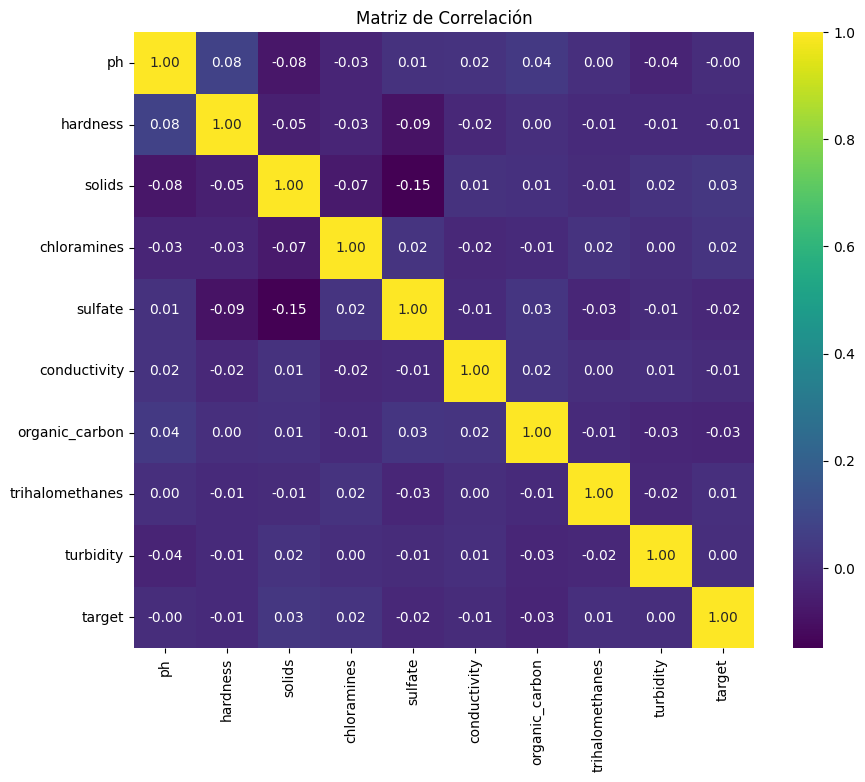

                   ph  hardness  solids  chloramines  sulfate  conductivity  \
ph               1.00      0.08   -0.08        -0.03     0.01          0.02   
hardness         0.08      1.00   -0.05        -0.03    -0.09         -0.02   
solids          -0.08     -0.05    1.00        -0.07    -0.15          0.01   
chloramines     -0.03     -0.03   -0.07         1.00     0.02         -0.02   
sulfate          0.01     -0.09   -0.15         0.02     1.00         -0.01   
conductivity     0.02     -0.02    0.01        -0.02    -0.01          1.00   
organic_carbon   0.04      0.00    0.01        -0.01     0.03          0.02   
trihalomethanes  0.00     -0.01   -0.01         0.02    -0.03          0.00   
turbidity       -0.04     -0.01    0.02         0.00    -0.01          0.01   
target          -0.00     -0.01    0.03         0.02    -0.02         -0.01   

                 organic_carbon  trihalomethanes  turbidity  target  
ph                         0.04             0.00      -0.04 

In [15]:
# Crear una matriz de correlación
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df_water.corr()

# Visualizar la matriz de correlación utilizando seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

# Imprimir la matriz de correlación con redondeo a 2 decimales
# print("Matriz de Correlación:")
print(correlation_matrix.round(2))

#### 1.3. Lectura de correlación

Correlaciones positivas (cercanas a 1)
- Ninguna

Correlaciones negativas (cercanas a -1)

Correlación Cercana a 0 (correlación débil o nula)

Nada reseñable.

### 1.4. Preparación de datos para el entrenamiento

In [16]:
from sklearn.model_selection import train_test_split

X = df_water.drop('target', axis=1)
y = df_water['target']

# Divide el DataFrame en conjuntos de entrenamiento y prueba 
train, test = train_test_split(df_water, test_size=0.33, random_state=42)

# Reseteo de índices
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

# Separación características y etiquetas
X_train = train.drop('target', axis=1)  
y_train = train['target']  
X_test = test.drop('target', axis=1)  
y_test = test['target']

print("Conjunto de entrenamiento:")
print(X_train.head()) 

print("\nConjunto de prueba:")
print(X_test.head())  


Conjunto de entrenamiento:
         ph    hardness        solids  chloramines     sulfate  conductivity  \
0  7.036752  158.207647  45243.028953     4.064878  247.180038    399.766965   
1  8.143483  182.432457  10673.582674     6.607835  333.073546    427.545219   
2  5.376078  185.540478  36026.401556     9.649943  343.486633    347.565066   
3  7.535700  221.792481  14829.745971     6.701159  366.412200    583.436488   
4  6.618187  164.254565  13776.621792     5.925462  333.073546    315.199393   

   organic_carbon  trihalomethanes  turbidity  
0       16.086232        53.502086   4.108857  
1       13.719331        77.769334   2.572830  
2       14.004449        66.622485   3.629250  
3       17.731882        59.686076   4.208354  
4       12.082169        61.474423   3.797068  

Conjunto de prueba:
         ph    hardness        solids  chloramines     sulfate  conductivity  \
0  7.036752  183.521107  20461.252710     7.333212  333.119476    356.369022   
1  6.643159  188.913541

## 2. Búsqueda de Parametrización con GridSearch y GradientBoosting

In [19]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

param_dist = {
    "n_estimators": [32, 64, 128],
    "learning_rate": [0.01, 0.05, 0.1, 0.25, 0.5],
    "max_features": ["sqrt"],# 'max_features' parameter of GradientBoostingClassifier must be a str among {'sqrt', 'log2'} or None. 
    "loss": ['log_loss'],
    "criterion": ['squared_error', 'friedman_mse'] # The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}.
}

# Aplicar GridSearchCV
grid_gb = GridSearchCV(GradientBoostingClassifier(), param_grid=param_dist, cv=5)
grid_gb.fit(X=train.drop(['target'], axis=1), y=train['target'])

# Obtener el mejor estimador
best_gb = grid_gb.best_estimator_

# fit y predecir utilizando el mejor estimador
y_pred = best_gb.predict(X=test.drop(['target'], axis=1))

# Evaluar
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.90      0.77       680
           1       0.60      0.25      0.35       402

    accuracy                           0.66      1082
   macro avg       0.63      0.57      0.56      1082
weighted avg       0.64      0.66      0.61      1082



## 3. Búsqueda de Parametrización con RandomizedSearch y GradientBoosting

In [20]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from scipy.stats import randint as sp_randint

param_dist = {"n_estimators": [4, 8, 16, 32, 64, 128], # Number of trees in random forest
                "max_features": ['sqrt'], # Number of features to consider at every node
                "max_depth": [16, 12,8,4, 2,None], # Maximum number of levels in tree
                "min_samples_split": sp_randint(2, 50), #  Minimum number of samples required to split a node
                "min_samples_leaf": sp_randint(1, 50), # Minimum number of samples required at each leaf node
                "criterion": ['friedman_mse', 'squared_error']
                }

# Aplicar GridSearchCV
grid_gb = RandomizedSearchCV(GradientBoostingClassifier(), param_distributions = param_dist, 
                            n_iter = 100, cv = 5, random_state=0, n_jobs = -1)
grid_gb.fit(X=train.drop(['target'], axis=1), y=train['target'])

# Obtener el mejor estimador
best_gb = grid_gb.best_estimator_

# fit y predecir utilizando el mejor estimador
y_pred = best_gb.predict(X=test.drop(['target'], axis=1))

# Evaluar
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.89      0.77       680
           1       0.59      0.25      0.35       402

    accuracy                           0.66      1082
   macro avg       0.63      0.57      0.56      1082
weighted avg       0.64      0.66      0.61      1082

